In [8]:
import os
import pandas as pd

import torch
from torch.utils.data import DataLoader, Dataset

from torchvision.io import read_image
from PIL import Image

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

## Exercise 1
Create the custom training set using the cifar10 images and targets

In [9]:
class CustomImageDataset(Dataset):
    def __init__(self, data, targets=None, transform=None, target_transform=None):
        self.imgs = data # Tensore di tutte le immagini
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx] # Sampling randomico di emlementi del dataset
        if isinstance(img, str): # Può capitare che il dataset sia salvato come stringhe/path (da usare quando non è possibile salvarsi tutto il tensore del dataset)
          img = read_image(img_path) # Fuzione di Torchvision, trova un'immaigne dal path fornito
        else:
          img = Image.fromarray(img.astype('uint8'), 'RGB')
        label = self.targets[idx] # Non utile nel caso di self-supervised ovviamente
        if self.transform:
            img = self.transform(img) # Utilizzo le trasformazioni
            # img = self.transform(img)  Già così genero due immagini augmented diverse, siccome le funzioni che trasformano sono randomiche (TODO, rivedi le variabili)
        if self.target_transform:
            label = self.target_transform(label)
        return img, label # Concateno immaigni e labels

In [34]:
# simclr DA pipeline
s=1
size=32
color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
transform = transforms.Compose([transforms.RandomResizedCrop(size=size),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomApply([color_jitter], p=0.8),
                                  transforms.RandomGrayscale(p=0.2),
                                  transforms.GaussianBlur(kernel_size=3),
                                  transforms.ToTensor()])

In [35]:
data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
# create training set from CustomDataset
trainset = CustomImageDataset(data.data, data.targets, transform=transform)
print(data.data)

Files already downloaded and verified
[[[[ 59  62  63]
   [ 43  46  45]
   [ 50  48  43]
   ...
   [158 132 108]
   [152 125 102]
   [148 124 103]]

  [[ 16  20  20]
   [  0   0   0]
   [ 18   8   0]
   ...
   [123  88  55]
   [119  83  50]
   [122  87  57]]

  [[ 25  24  21]
   [ 16   7   0]
   [ 49  27   8]
   ...
   [118  84  50]
   [120  84  50]
   [109  73  42]]

  ...

  [[208 170  96]
   [201 153  34]
   [198 161  26]
   ...
   [160 133  70]
   [ 56  31   7]
   [ 53  34  20]]

  [[180 139  96]
   [173 123  42]
   [186 144  30]
   ...
   [184 148  94]
   [ 97  62  34]
   [ 83  53  34]]

  [[177 144 116]
   [168 129  94]
   [179 142  87]
   ...
   [216 184 140]
   [151 118  84]
   [123  92  72]]]


 [[[154 177 187]
   [126 137 136]
   [105 104  95]
   ...
   [ 91  95  71]
   [ 87  90  71]
   [ 79  81  70]]

  [[140 160 169]
   [145 153 154]
   [125 125 118]
   ...
   [ 96  99  78]
   [ 77  80  62]
   [ 71  73  61]]

  [[140 155 164]
   [139 146 149]
   [115 115 112]
   ...
   [ 79

In [36]:
dataloader = DataLoader(trainset, batch_size=64, shuffle=True)
print(dataloader)

Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


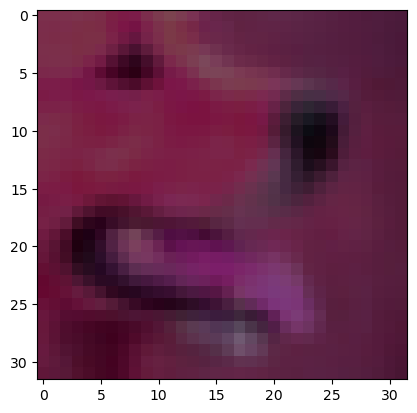

Label: 5


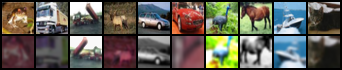

In [15]:
# Display image and label.
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze().permute(1, 2, 0)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")


# use this
notransform = transforms.Compose([transforms.ToTensor()])
non_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, transform=notransform)


from torchvision.utils import make_grid
imgs = torch.stack((*[non_augmented[i][0] for i in range(10)],
                    *[trainset[i][0] for i in range(10)]))

#imgs_custom = torch.stack((*[non_augmented[i][0] for i in range(10)],
#                    *[trainset[i][0] for i in range(10)],
#                    *[trainset[i][1] for i in range(10)]))
grid = make_grid(imgs, nrow=10)

transforms.ToPILImage()(grid)

In [ ]:
# this is the example

for idx, data in enumerate(dataloader):
    images1, targets1 = data
    print(images1.shape)
    print(targets1.shape)
    if idx == 3:
        break

torch.Size([64, 3, 32, 32])
torch.Size([64])
torch.Size([64, 3, 32, 32])
torch.Size([64])
torch.Size([64, 3, 32, 32])
torch.Size([64])
torch.Size([64, 3, 32, 32])
torch.Size([64])


## Exercise 2
Modify the custom dataset to return two different views of an input image and create a train loop as the following example

In [16]:
class CustomImageDatasetBis(Dataset):
    def __init__(self, data, targets=None, transform=None, target_transform=None):
        self.imgs = data # Tensore di tutte le immagini
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx] # Sampling randomico di emlementi del dataset
        if isinstance(img, str): # Può capitare che il dataset sia salvato come stringhe/path (da usare quando non è possibile salvarsi tutto il tensore del dataset)
          img = read_image(img_path) # Fuzione di Torchvision, trova un'immaigne dal path fornito
        else:
          img = Image.fromarray(img.astype('uint8'), 'RGB')
        label = self.targets[idx] # Non utile nel caso di self-supervised ovviamente
        if self.transform:
            img1 = self.transform(img) # Utilizzo le trasformazioni
            img2 = self.transform(img)
            # img = self.transform(img)  Già così genero due immagini augmented diverse, siccome le funzioni che trasformano sono randomiche (TODO, rivedi le variabili)
        if self.target_transform:
            label1 = self.target_transform(label)
            label2 = self.target_transform(label)
        else:
            label1 = label
            label2 = label
        return img1, img2, label1, label2 # Concateno immaigni e labels
    

Files already downloaded and verified
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


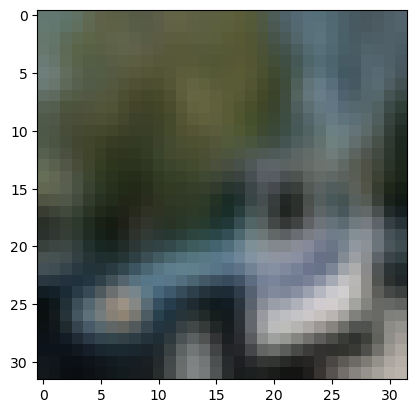

Label: 1


In [ ]:
data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
trainset = CustomImageDatasetBis(data.data, data.targets, transform=transform)
dataloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Display image and label.
train_features1, train_features2, train_labels1, train_labels2 = next(iter(dataloader))
print(f"Feature batch shape: {train_features1.size()}")
print(f"Labels batch shape: {train_labels1.size()}")
img = train_features1[0].squeeze().permute(1, 2, 0)
img1 = train_features2[0].squeeze().permute(1, 2, 0)
label = train_labels1[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# TODO ask about training loop

In [ ]:
for idx, data in enumerate(dataloader):
    images, targets, l1, l2 = data
    print(images.shape)
    print(targets.shape)
    if idx == 3:
        break

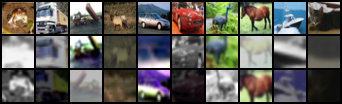

In [25]:
# use this
notransform = transforms.Compose([transforms.ToTensor()])
non_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, transform=notransform)


from torchvision.utils import make_grid


imgs = torch.stack((*[non_augmented[i][0] for i in range(10)],
                    *[trainset[i][0] for i in range(10)],
                    *[trainset[i][1] for i in range(10)]))
grid = make_grid(imgs, nrow=10)
transforms.ToPILImage()(grid)


## Exercise 3

Plot a positive pair and a negative pair of a mini-batch of sample

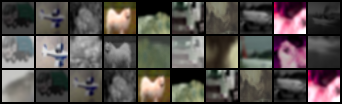

In [32]:
positive1, positive2, label1, label2 = next(iter(dataloader))

imgs = torch.stack((*[positive1[i] for i in range(10)],
                    *[positive2[i] for i in range(10)],
                    *[positive1[i - 1] for i in range(10)]))
grid = make_grid(imgs, nrow=10)
transforms.ToPILImage()(grid)